In [28]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial
from matplotlib.patches import Circle, Rectangle
import random
import sys
import os

# don't hate me
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=FutureWarning)

if "../workflow/scripts" not in sys.path:
    sys.path.insert(0, os.path.abspath("../../workflow/scripts"))
from plotting import plots

settings = "r100tc-10aINTERg0.99"

RESULTS_DIR = f"{settings}"
# RESULTS/RESULTSNOTRAP/r100tc-100aINTERg0.99/a0/J_0.pickle
#df = pd.read_csv("a0/df_0.csv")


# start with 0-no-trap
condition = "2-no-trap"
PLOT_DIR = f"PLOTS/{settings}/{condition}/single"
CONDITION_DIR = f"{RESULTS_DIR}/{condition}"
AGENT_NUMBER = len(os.listdir(CONDITION_DIR))

agent_ids = [1]#[i for i in range(0,AGENT_NUMBER)]
sample_ids = [1]#random.sample(agent_ids, min(AGENT_NUMBER, 5))

SAVE_PLOTS = False

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
    print("Directory " , PLOT_DIR ,  " Created ")
else:    
    print("Directory " , PLOT_DIR ,  " already exists")


Directory  PLOTS/r100tc-10aINTERg0.99/2-no-trap/single  Created 


In [29]:
def centroid(data):
    x, y = zip(*data)
    l = len(x)
    return int(round(sum(x) / l)), int(round(sum(y) / l))

with open("../../Wystrach2020/env.pickle", 'rb') as env_pickled:
    env = pickle.load(env_pickled)
env['goal'] = centroid(env.pop('goals'))
traps = env["traps"]
trap_exits = env["trap_exits"]

In [30]:
titles = {
  "0-no-trap": "trap covered",
  "1-trap": "trap uncovered",
  "2-no-trap": "trap covered again"
}

In [31]:
def plot_line(data_name, title, xlabel, ylabel):
  SMOOTHING_FACTOR = 10

  data = []
  for i in agent_ids:
    with open(f"{CONDITION_DIR}/a{i}/{data_name}_{i}.pickle",'rb') as f_in:
      data.append(pickle.load(f_in))
  # Smoothing by Factor  
  data_tupls = []
  N = SMOOTHING_FACTOR
  for D in data:
    D = np.convolve(D, np.ones(N)/N, mode='valid')
    for idx, d in enumerate(D):
      data_tupls.append((idx,d))
  df_data = pd.DataFrame(data_tupls, columns = ['x', 'y'])

  sns.lineplot(data=df_data, x="x", y="y", ci='sd')
  ax = plt.gca()
  #ax.set_ylim(df_J.y.min(),df_J.y.max() +2)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)


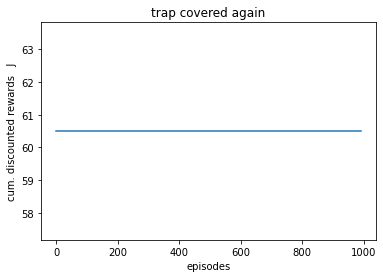

In [32]:
plot_line(data_name='J', title=titles[condition] , xlabel='episodes', ylabel='cum. discounted rewards   J')
if SAVE_PLOTS:
  plt.savefig(f"{PLOT_DIR}/J_a0.svg")

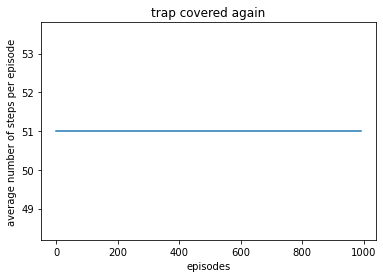

In [33]:
plt.clf()
plot_line(data_name='episode_lens', title=titles[condition] , xlabel='episodes', ylabel='average number of steps per episode')

In [34]:
samples = []
for idx, i in enumerate(agent_ids):
    df = pd.read_csv(f"{CONDITION_DIR}/a{i}/df_{i}.csv")
    samples.append(df)


last_trials = [ant_df[ant_df.trial_nb == ant_df.trial_nb.max()] for ant_df in samples]
#last_trials[0]

MANUALLY CHANGES CODE HERE TO ACCOUNT FOR SIMULATION ERROR OF WRONG STARTING POINT


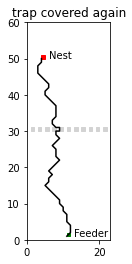

In [35]:
ax = plt.subplot()
ax.set_xlim(0,env["width"])
ax.set_ylim(0,env["height"])
ax.set_aspect('equal')

#traps = env["traps"]
#trap_exits = env["trap_exits"]

patches = [
    
    Rectangle(env["goal"], width=1, height=1, color='red'),
    #Rectangle((1,11), width=1, height=1, color='green')    
    Rectangle(env["start"], width=1, height=1, color='green') # wrong in simulation
    #Rectangle(trap_exits[0][0], width=.5, height=2, color='black'),
    #Rectangle(trap_exits[1][0], width=.5, height=2, color='black')
]
if condition=="1-trap":
    patches.extend([Rectangle(trap, width=1, height=1, color='lightgray') for trap in traps])
else:
    patches.extend([Rectangle(trap, width=1, height=1, color='lightgray') for trap in traps[::2]])
for patch in patches:
    ax.add_patch(patch)

ax.annotate('Feeder', (env['start'][0] + 2, env['start'][1]))
ax.annotate('Nest', (env['goal'][0] + 2, env['goal'][1]))
ax.set_title(titles[condition])
for ant_df in last_trials:
    plots.draw_trajectories_phil(ant_df, ax)
print("MANUALLY CHANGES CODE HERE TO ACCOUNT FOR SIMULATION ERROR OF WRONG STARTING POINT")
if SAVE_PLOTS:
    plt.savefig(f"{PLOT_DIR}/all_last_trajectories_0.svg")

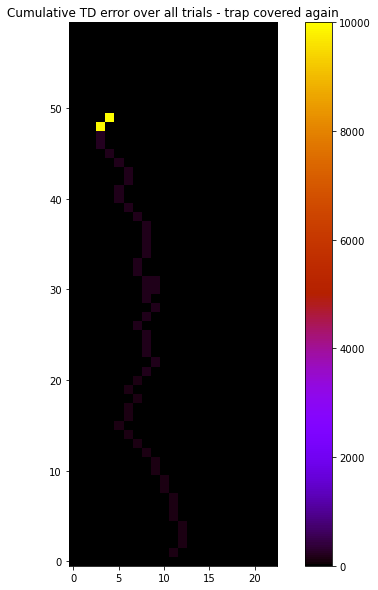

In [36]:
tds_ns_list = []
for i in agent_ids:
  with open(f"{CONDITION_DIR}/a{i}/tds_ns_{i}.npy",'rb') as f_in:
    tds_ns_list.append(np.load(f_in))
# creating mean over all agents
all_agent_mean_tds_ns = np.array(tds_ns_list).mean(axis=0)

plt.figure(figsize=(10,10))
plt.imshow(all_agent_mean_tds_ns[::-1], origin='lower', cmap="gnuplot")
#plt.title("Mean TD error over all agents and all trials")
plt.title(f"Cumulative TD error over all trials - {titles[condition]}")
plt.colorbar()
if SAVE_PLOTS:
    plt.savefig(f"{PLOT_DIR}/td_error_a0.svg")


<Figure size 432x288 with 0 Axes>

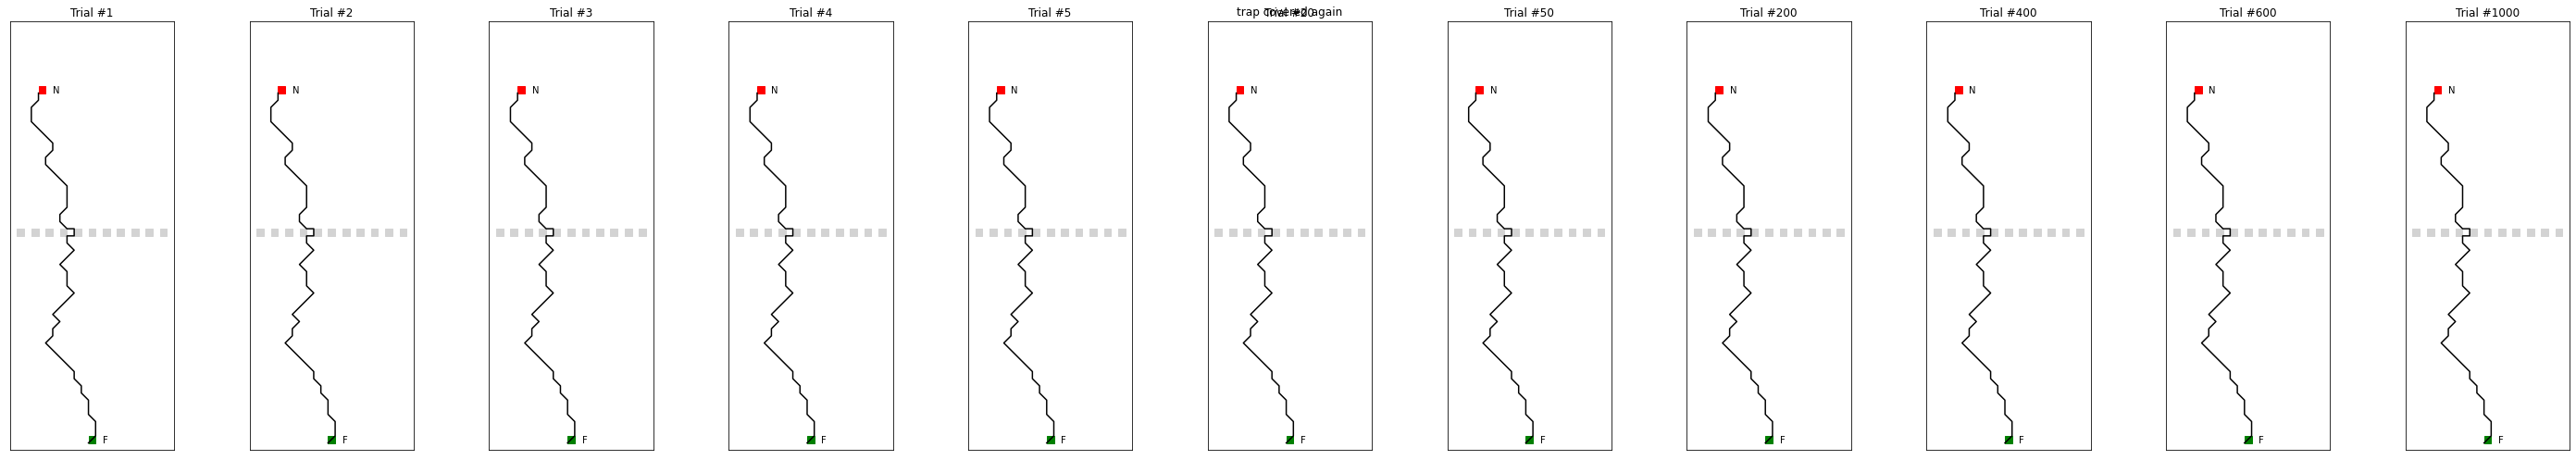

In [37]:
plt.clf()
trial_samples = [1,2,3,4,5,20,50,200,400,600,1000]# 250, 500, 750, 1000]
fig, axs = plt.subplots(nrows=1, ncols=len(trial_samples), sharey=True, figsize=(40, 7))
#cs = iter(cm.rainbow(np.linspace(0, 1, len(trial_samples))))

for df_ant in samples:
  # per ant
  for idx,trial_sample in enumerate(trial_samples):

    df_subsample = df_ant[df_ant.trial_nb == trial_sample-1]
    ax = axs[idx]#plt.subplot(1,len(trial_samples),idx+1)
    plt.sca(ax)
    plots.draw_trajectories_phil(df_subsample, ax)

    ax.set_xlim(0,env["width"])
    ax.set_ylim(0,env["height"])
    ax.set_aspect('equal')
    ax.set_title(f"Trial #{trial_sample}")
    ax.set_xticks([])
    ax.set_yticks([])

    patches = [
    Rectangle(env["goal"], width=1, height=1, color='red'),
    Rectangle(env["start"], width=1, height=1, color='green')    
    ]
    if condition=="1-trap":
      patches.extend([Rectangle(trap, width=1, height=1, color='lightgray') for trap in traps])
    else:
      patches.extend([Rectangle(trap, width=1, height=1, color='lightgray') for trap in traps[::2]])

    for patch in patches:
      ax.add_patch(patch)    
    ax.annotate('F', (env['start'][0] + 2, env['start'][1]))
    ax.annotate('N', (env['goal'][0] + 2, env['goal'][1]))
plt.tight_layout()
plt.suptitle(titles[condition])

if SAVE_PLOTS:
    plt.savefig(f"{PLOT_DIR}/Traj_all_trials_0.svg")

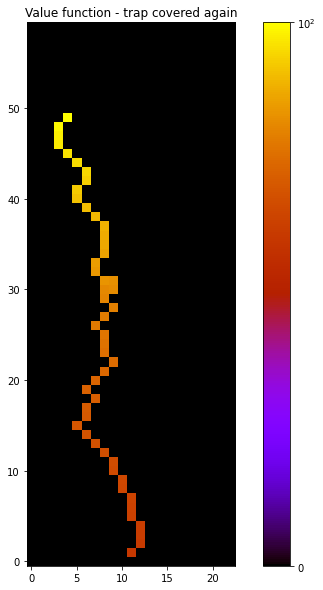

In [38]:
from matplotlib.colors import SymLogNorm

value_list = []
for i in agent_ids:
  with open(f"{CONDITION_DIR}/a{i}/value_fun_{i}.npy",'rb') as f_in:
    value_list.append(np.load(f_in))
# creating mean over all agents
all_agent_mean_value = np.array(value_list).mean(axis=0)

plt.figure(figsize=(10,10))
plt.imshow(all_agent_mean_value[::-1], origin='lower', cmap="gnuplot", norm=SymLogNorm(100))
plt.title(f"Value function - {titles[condition]}")
plt.colorbar()
if SAVE_PLOTS:
    plt.savefig(f"{PLOT_DIR}/Value_Func_Mean_0.svg")